In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#colabを使う方はこちらを使用ください。
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib
!pip install pillow
!pip install opencv-python
!pip install cnn-finetune

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for cnn-finetune: filename=cnn_finetune-0.6.0-cp36-none-any.whl size=11432 sha256=ec87ec3115707db4db914c07c7bba61dda2049b293a55620f8c55583732e1618
  Stored in directory: /root/.cache/pip/wheels/12/4f/29/32978e72b606c5f51b6bd10117814deb46c6b63230eef49381
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=443343a243e83572f90e85eda3797184c319e1884fc928ea2da3daee7a126468
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built cnn-finetune pretrainedmodels




---


**Image Recognition for CIFAR10 with Inception v3**
---





In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import math
import random

**Set Train and Test Dataset**

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transform,
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Set Train and Test Loader**

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

Function For Showing Image

In [0]:
def show(img):
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)),interpolation='nearest')

Sample Showing

[0 0 5 7 1 7 5 9 6 1 1 0 0 6 0 0 8 1 2 5 1 3 7 0 3 8 2 4 0 2 0 4 0 0 0 0 9
 3 1 9 0 3 0 2 6 1 8 6 8 3 1 7 8 5 9 8 6 9 1 8 3 3 5 9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


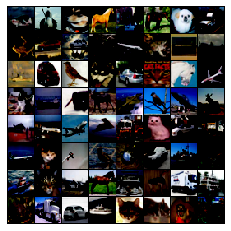

In [0]:
for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      print(labels.numpy())
      show(torchvision.utils.make_grid(images,padding=1))
      plt.axis('off')
      break

Set Model Class(Inception and Google Net)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# net = GoogLeNet()
# x = torch.randn(1,3,32,32)
# y = net(Variable(x))
# print(y.size())

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = GoogLeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

In [0]:
print(device)

cuda


In [14]:
num_epochs = 50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        #view()での変換をしない
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0191, val_loss: 0.0151, val_acc: 0.6618
Epoch [2/50], Loss: 0.0120, val_loss: 0.0112, val_acc: 0.7520
Epoch [3/50], Loss: 0.0092, val_loss: 0.0124, val_acc: 0.7431
Epoch [4/50], Loss: 0.0076, val_loss: 0.0093, val_acc: 0.7980
Epoch [5/50], Loss: 0.0064, val_loss: 0.0083, val_acc: 0.8209
Epoch [6/50], Loss: 0.0054, val_loss: 0.0080, val_acc: 0.8262
Epoch [7/50], Loss: 0.0046, val_loss: 0.0075, val_acc: 0.8520
Epoch [8/50], Loss: 0.0038, val_loss: 0.0074, val_acc: 0.8508
Epoch [9/50], Loss: 0.0032, val_loss: 0.0069, val_acc: 0.8589
Epoch [10/50], Loss: 0.0026, val_loss: 0.0086, val_acc: 0.8375
Epoch [11/50], Loss: 0.0022, val_loss: 0.0076, val_acc: 0.8619
Epoch [12/50], Loss: 0.0020, val_loss: 0.0085, val_acc: 0.8469
Epoch [13/50], Loss: 0.0016, val_loss: 0.0082, val_acc: 0.8555
Epoch [14/50], Loss: 0.0014, val_loss: 0.0081, val_acc: 0.8614
Epoch [15/50], Loss: 0.0013, val_loss: 0.0087, val_acc: 0.8665
Epoch [16/50], Loss: 0.0012, val_loss: 0.0101, val_acc: 0.8600
E

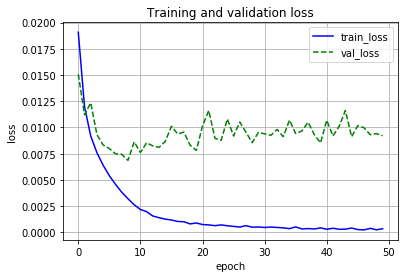

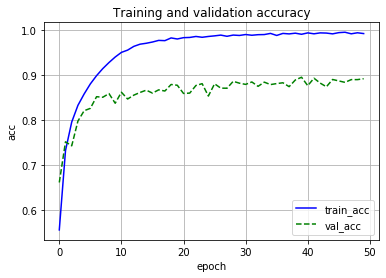

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()